In [1]:
import torch
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from tqdm import tqdm
from torchvision.transforms import v2

(3, 1, 1)


c:\ProgramData\anaconda3\envs\diffusion_nn\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


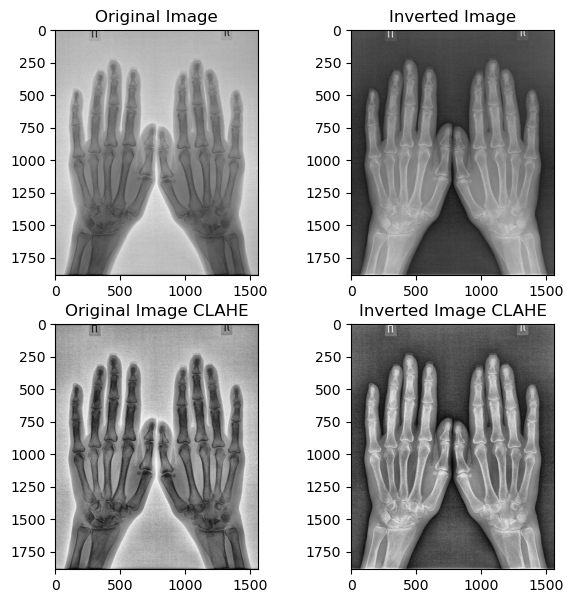

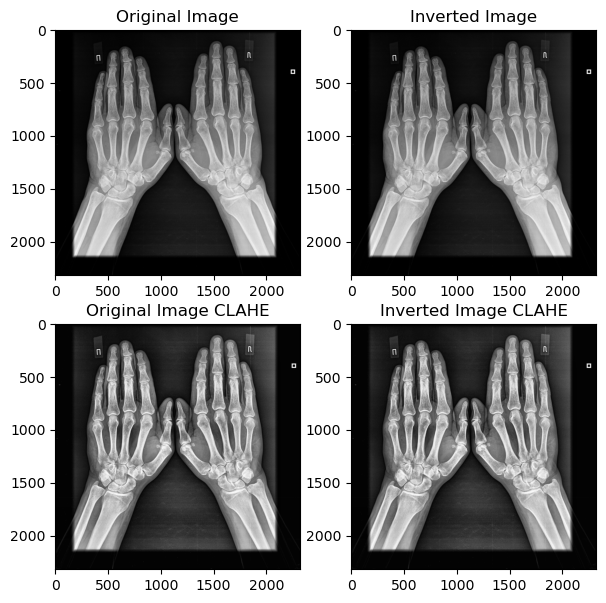

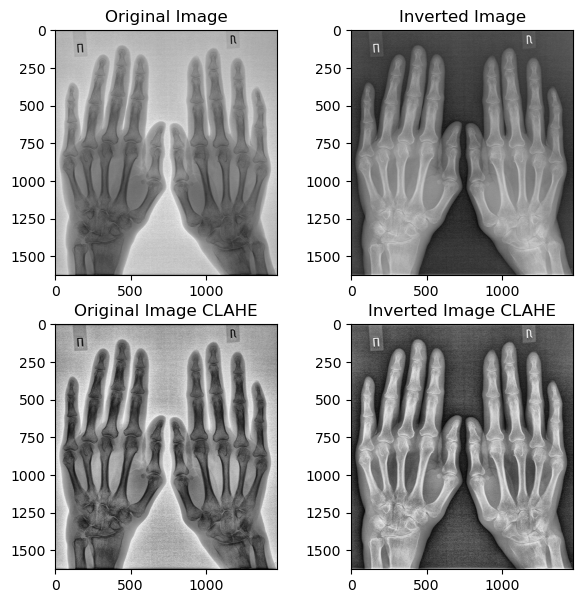

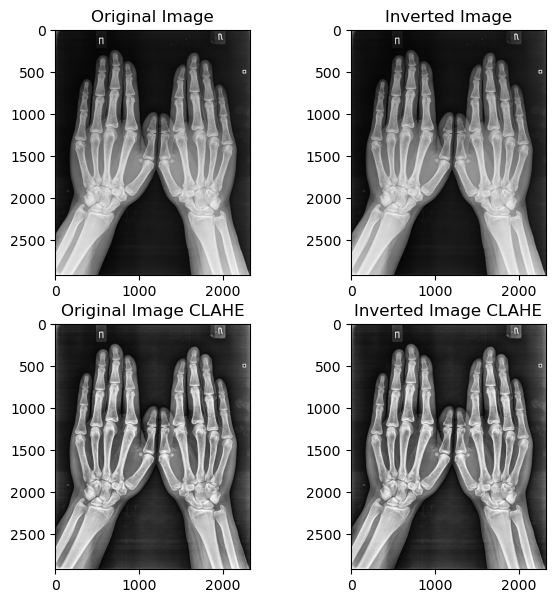

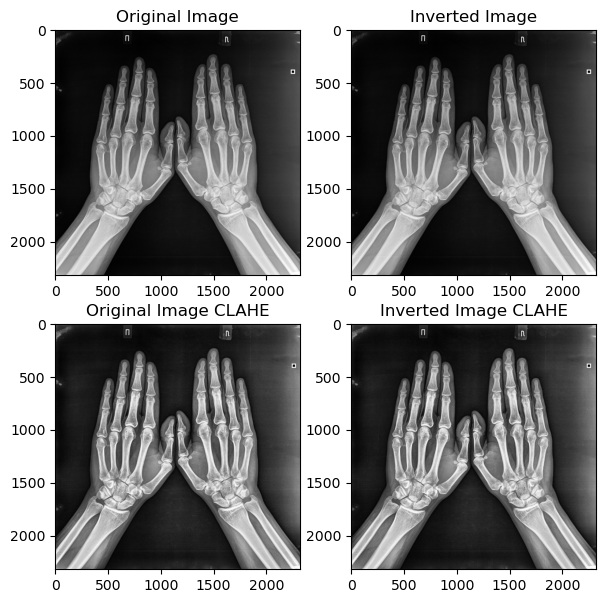

In [ ]:
# invertion

mean = np.array([[[0.485]], [[0.456]], [[0.406]]])
std = np.array([[[0.229]], [[0.224]], [[0.225]]])

def clahe(pil_image):
    rgb_image = rgb_image = np.array(pil_image)
    r, g, b = cv2.split(rgb_image)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Apply CLAHE to each channel
    r_clahe = clahe.apply(r)
    g_clahe = clahe.apply(g)
    b_clahe = clahe.apply(b)

    # Merge the CLAHE-enhanced channels back into an RGB image
    rgb_clahe_image = cv2.merge((r_clahe, g_clahe, b_clahe))
    return Image.fromarray(rgb_clahe_image)

def preprocess_image(image_path):
    transform = v2.Compose([
        v2.ToTensor(),
        #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image_cl = clahe(Image.open(image_path).convert('RGB'))
    return transform(image), transform(image_cl)

def show_images(original, transformed, img_tensor_cl, img_tensor_inv_cl):
    fig, ax = plt.subplots(2, 2, figsize=(7, 7))
    ax = ax.flatten()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Оригинальное изображение
    orig_denorm = original.permute(1, 2, 0).numpy() #* std + mean
    ax[0].imshow(np.clip(orig_denorm, 0, 1))
    ax[0].set_title("Original Image")
    
    # Трансформированное изображение
    trans_denorm = transformed.permute(1, 2, 0).numpy() #* std + mean
    ax[1].imshow(np.clip(trans_denorm, 0, 1))
    ax[1].set_title("Inverted Image")
 
    orig_denorm_1 = img_tensor_cl.permute(1, 2, 0).numpy() #* std + mean
    ax[2].imshow(np.clip(orig_denorm_1, 0, 1))
    ax[2].set_title("Original Image CLAHE")

    trans_denorm_1 = img_tensor_inv_cl.permute(1, 2, 0).numpy() #* std + mean
    ax[3].imshow(np.clip(trans_denorm_1, 0, 1))
    ax[3].set_title("Inverted Image CLAHE")
    
    plt.show()

def get_inv(img_tensor):
    mean = img_tensor.float().mean()
    #print(mean)
    if mean > 0.4:
        return v2.functional.invert(img_tensor)
    else:
        return img_tensor

os.makedirs(os.path.join('dataset', 'eval_data_inv_clahe'), exist_ok=True)
for i, file_name in enumerate(os.listdir(os.path.join('dataset', 'eval_data'))):
    img_tensor, img_tensor_cl = preprocess_image(os.path.join('dataset', 'eval_data', file_name))
    img_tensor_inv = get_inv(img_tensor)
    img_tensor_inv_cl = get_inv(img_tensor_cl)

    if i < 5:
        show_images(img_tensor, img_tensor_inv, img_tensor_cl, img_tensor_inv_cl)

    img = v2.functional.to_pil_image(img_tensor_inv_cl) #* std + mean)
    img.save(os.path.join('dataset', 'eval_data_inv_clahe', file_name))

In [18]:
import pandas as pd

def count_disbalance(df, param):
    d = {}
    for column in df.columns:
        vals = df[column].to_list()
        s = sum(vals)
        for i, v in enumerate(vals):
            if v > s * .5:
                d[f'{column}_{param}'] = str(i)
                break
        else:
            d[f'{column}_{param}'] = 'balanced'
    return d

erosion_df = pd.read_csv(os.path.join('dataset', 'non-sorted', 'erosion_data_counts.csv'), header = 0, index_col=0)
jsn_df = pd.read_csv(os.path.join('dataset', 'non-sorted', 'jsn_data_counts.csv'), header = 0, index_col=0)
er_d, jsn_d = count_disbalance(erosion_df, 'erosion'), count_disbalance(jsn_df, 'jsn')
full_dict = dict(list(er_d.items()) + list(jsn_d.items()))

def make_res_dataset(ids):
    data = []
    for id in ids:
        for i in range(100):
            data.append([f'{id}_{i}', id, i])

    res_df = pd.DataFrame(data = data, columns = ['ID', 'patient_id', 'joint_id'])
    res_df['xcenter'] = None
    res_df['ycenter'] = None
    res_df['dx'] = None
    res_df['dy'] = None
    res_df['jsn_score'] = None
    res_df['erosion_score'] = None
    res_df['PAD'] = 1.0

    return res_df
        

yolo_data = pd.read_csv(os.path.join('dataset', 'detections_all_42.csv'))
res_df= make_res_dataset(yolo_data['patient_id'].unique())
yolo_data.head()
res_df.head()

ID  patient_id  joint_id xcenter ycenter    dx    dy jsn_score  \
0  14_0          14         0    None    None  None  None      None   
1  14_1          14         1    None    None  None  None      None   
2  14_2          14         2    None    None  None  None      None   
3  14_3          14         3    None    None  None  None      None   
4  14_4          14         4    None    None  None  None      None   

  erosion_score  PAD  
0          None  1.0  
1          None  1.0  
2          None  1.0  
3          None  1.0  
4          None  1.0

In [19]:
def find_model(model_type, damage_type, joint_type):
    if model_type == 'balanced':
        a = f'effNetb4_{joint_type}_{damage_type}'
    else:
        a = f'{model_type}_effNetb4_{joint_type}_{damage_type}'

    for p in os.listdir('models'):
        if p.startswith(a):
            return os.path.join('models', p)

def preprocess_image(image):
    transform = v2.Compose([
        v2.Resize((224, 224)),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image)

def test_time_augmentations(preds, inputs, model):
    inp_rot_p10 = v2.functional.rotate(inputs, 10)
    inp_rot_m10 = v2.functional.rotate(inputs, -10)

    with torch.no_grad():
        preds += model(v2.functional.horizontal_flip(inputs))
        preds += model(v2.functional.horizontal_flip(inp_rot_p10))
        preds += model(v2.functional.horizontal_flip(inp_rot_m10))
        preds += model(inp_rot_p10)
        preds += model(inp_rot_m10)
    return preds

def get_preds_tta(preds, inputs, majour_class, minor_model):
    majour_class = int(majour_class)
    with torch.no_grad():
        y_pred = torch.empty((preds.shape[0],))
        for i, item in enumerate(inputs):
            if torch.argmax(preds[i]).item() == 1:
                y_pred[i] = majour_class
            else:
                pr = minor_model(item.unsqueeze(0))
                pr = test_time_augmentations(pr, item.unsqueeze(0), minor_model)
                pred = torch.argmax(pr).item()
                y_pred[i] = pred if pred < majour_class else pred + 1
    return y_pred

def predict_test_majour_class(bin_model, minor_model, test_image, majour_class):
    bin_model.eval()
    minor_model.eval()
    with torch.no_grad():
        pred = bin_model(test_image.unsqueeze(0))
        y_pred_tta = get_preds_tta(test_time_augmentations(pred, test_image.unsqueeze(0), bin_model),
                                    test_image.unsqueeze(0), majour_class, minor_model)
    return y_pred_tta

def predict_test_balanced(model, test_image):
    model.eval()
    with torch.no_grad():
        pred = model(test_image.unsqueeze(0))
        y_pred_tta = test_time_augmentations(pred, test_image.unsqueeze(0), model).argmax(dim=1).item()
    return y_pred_tta

def get_label(test_image, model_type, damage_type, joint_type, device):
    if joint_type == 'ulna' and damage_type == 'jsn':
        return 0 # all ulna samples from 'jpeg' data had jsn_score = 0
    
    test_image = test_image.to(device)
    if model_type == 'balanced':
        model = torch.load(find_model(model_type, damage_type, joint_type))
        return predict_test_balanced(model, test_image)
    else:
        majour_class = model_type
        bin_model = torch.load(find_model('bin', damage_type, joint_type))
        minor_model = torch.load(find_model('minor', damage_type, joint_type))
        return predict_test_majour_class(bin_model, minor_model, test_image, majour_class)

def crop_and_evaluate_images(merged_df, res_df, full_dict, image_dir, output_dir, normalized=False):
    """
    Crop images based on bounding boxes and get predictions them with the appropriate label.

    Args:
        merged_df (pd.DataFrame): Merged DataFrame containing bbox and label information.
        image_dir (str): Path to the directory containing input images.
        output_dir (str): Path to save the cropped images.
        normalized (bool): Whether the bounding box coordinates are normalized.
    """             
    os.makedirs(output_dir, exist_ok=True)
    pat_joint_counts = {}

    for i, row in merged_df.iterrows():
        image_name = str(row["patient_id"]) + ".jpeg"  # Assuming the image name is in a column called "image_name"
        pat_joint_counts[row["patient_id"]] = pat_joint_counts.get(row["patient_id"], -1) + 1
        joint_id = pat_joint_counts[row["patient_id"]]
        joint_type = row['joint']
        x_center, y_center, width, height = row["xcenter"], row["ycenter"], row["dx"], row["dy"]

        # Load the image
        image_path = os.path.join(image_dir, image_name)
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        # Get image dimensions
        img_height, img_width = image.shape[:2]

        # Convert normalized coordinates to pixel coordinates if necessary
        if normalized:
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
        
        ### revrite yolo_df
        ind = res_df.index[res_df['ID'] == f'{row['patient_id']}_{joint_id}']
        res_df.loc[ind, 'joint_id'] = joint_id
        res_df.loc[ind, 'xcenter'] = x_center/img_width
        res_df.loc[ind, 'ycenter'] = y_center/img_height
        res_df.loc[ind, 'dx'] = width/img_width
        res_df.loc[ind, 'dy'] = height/img_height

    #set bounding boxes sizes equal for each joint type
    for id, sub_df in yolo_data.groupby('patient_id'):
        sub_df['dx'] = sub_df.groupby('joint')['dx'].transform('max')
        sub_df['dy'] = sub_df.groupby('joint')['dy'].transform('max')
    
    pat_joint_counts = {}
    for i, row in merged_df.iterrows():
        image_name = str(row["patient_id"]) + ".jpeg"  # Assuming the image name is in a column called "image_name"
        pat_joint_counts[row["patient_id"]] = pat_joint_counts.get(row["patient_id"], -1) + 1
        joint_id = pat_joint_counts[row["patient_id"]]
        joint_type = row['joint']
        x_center, y_center, width, height = row["xcenter"], row["ycenter"], row["dx"], row["dy"]

        # Load the image
        image_path = os.path.join(image_dir, image_name)
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        
        # Get image dimensions
        img_height, img_width = image.shape[:2]
        # Calculate bounding box coordinates
        x1 = max(int(x_center - width / 2), 0)
        y1 = max(int(y_center - height / 2), 0)
        x2 = min(int(x_center + width / 2), img_width)
        y2 = min(int(y_center + height / 2), img_height)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # Crop the image
        cropped_image = image[y1:y2, x1:x2]
        cropped_image = preprocess_image(cropped_image)

        ind = res_df.index[res_df['ID'] == f'{row['patient_id']}_{joint_id}']

        res_df.loc[ind, 'erosion_score'] = get_label( cropped_image, full_dict[f'{joint_type}_erosion'], 'erosion', joint_type, device)
        res_df.loc[ind, 'jsn_score'] = get_label(cropped_image, full_dict[f'{joint_type}_jsn'], 'jsn', joint_type, device)
        res_df.loc[ind, 'PAD'] = 0.0


        # Save the cropped image
        '''os.makedirs(os.path.join(output_dir, joint_type), exist_ok=True)
        output_name = f"{os.path.splitext(image_name)[0]}_{i}.jpg"
        output_path = os.path.join(output_dir, joint_type, output_name)
        try:
            cv2.imwrite(output_path, cropped_image)
        except:
            print(cropped_image.shape)
            print(row)
            return 0'''
    return res_df

# Crop and save images
res_df = crop_and_evaluate_images(yolo_data, res_df, full_dict, os.path.join('dataset','eval_data_inv_clahe'), os.path.join('dataset','eval_data_cropped_inv_clahe'), False)
res_df.to_csv(os.path.join('dataset', 'results.csv'))
res_df.head(40)

c:\ProgramData\anaconda3\envs\diffusion_nn\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_9072\2891136526.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they a

ID  patient_id  joint_id   xcenter   ycenter        dx        dy  \
0    14_0          14         0  0.149932    0.4877  0.093623  0.123001   
1    14_1          14         1  0.761194  0.819188  0.272727  0.143911   
2    14_2          14         2  0.220488  0.792128  0.274084  0.135916   
3    14_3          14         3  0.066486   0.52337  0.092266  0.109471   
4    14_4          14         4  0.563772  0.621156  0.097693  0.098401   
5    14_5          14         5  0.835821   0.50984  0.090909  0.123001   
6    14_6          14         6  0.444369  0.618081  0.103121  0.103321   
7    14_7          14         7  0.918589   0.54797  0.089552  0.113161   
8    14_8          14         8  0.746947   0.48524  0.103121  0.122386   
9    14_9          14         9  0.240163  0.468635  0.105834  0.124231   
10  14_10          14        10  0.350746    0.4631  0.100407  0.121771   
11  14_11          14        11  0.634328  0.298278  0.087517  0.076876   
12  14_12          14        12  0.644505  0.482165   0.10787  0.124846   
13  14_13          14        13  0.449796   0.47417  0.078019  0.062116   
14  14_14          14        14  0.626866  0.191882  0.072592  0.059656   
15  14_15          14        15  0.177748  0.300123  0.085482  0.075646   
16  14_16          14        16  0.550882   0.48032  0.073948  0.065191   
17  14_17          14        17  0.074627  0.375769  0.070556  0.059041   
18  14_18          14        18  0.721845  0.287823  0.088874  0.078721   
19  14_19          14        19  0.708277  0.162977  0.073948  0.066421   
20  14_20          14        20  0.278833  0.271218  0.090231  0.078106   
21  14_21          14        21  0.823609  0.322263  0.080733  0.071341   
22  14_22          14        22  0.369064  0.284133  0.085482  0.071956   
23  14_23          14        23  0.915197  0.400369  0.067843  0.056581   
24  14_24          14        24  0.380597  0.179582  0.071913  0.056581   
25  14_25          14        25  0.296472  0.150062  0.075305  0.065806   
26  14_26          14        26    0.1981  0.185117  0.075984  0.060271   
27  14_27          14        27  0.070556  0.292743  0.059701  0.049815   
28  14_28          14        28  0.819539  0.206642   0.07327  0.062116   
29  14_29          14        29  0.166893  0.710947  0.069878  0.063961   
30  14_30          14        30  0.125509  0.726937  0.075984  0.060271   
31  14_31          14        31  0.354817  0.765683  0.071913  0.065191   
32  14_32          14        32  0.895522  0.866544  0.089552  0.063346   
33  14_33          14        33  0.819539  0.733087  0.069878  0.061501   
34  14_34          14        34  0.918589  0.314268  0.061058  0.052276   
35  14_35          14        35  0.770692  0.738622  0.072592  0.061501   
36  14_36          14        36  0.857531  0.752153  0.076662  0.060271   
37  14_37          14        37  0.215061  0.715867  0.076662  0.060271   
38  14_38          14        38  0.781547  0.894834  0.184532  0.051046   
39  14_39          14        39  0.626187  0.781673  0.076662  0.063961   

   jsn_score erosion_score  PAD  
0          2           0.0  0.0  
1          2             0  0.0  
2          3             0  0.0  
3          2           0.0  0.0  
4          1           0.0  0.0  
5          2           0.0  0.0  
6          2           0.0  0.0  
7          2           0.0  0.0  
8          3           0.0  0.0  
9          2           0.0  0.0  
10         2           0.0  0.0  
11         2           0.0  0.0  
12         2           0.0  0.0  
13         2           0.0  0.0  
14         2           0.0  0.0  
15         2           0.0  0.0  
16         0           0.0  0.0  
17         0           0.0  0.0  
18         2           0.0  0.0  
19         0           0.0  0.0  
20         2           0.0  0.0  
21         2           0.0  0.0  
22         2           0.0  0.0  
23         0           0.0  0.0  
24         2           0.0  0.0  
25         0           0.0  0.0  
26         0 

In [31]:
def change_res_dataset(ids, res_df):
    ids_c = []
    j_id_c = []
    for id in ids:
        for i in range(1, 101):
            ids_c.append(f'{id}_{i}')
            j_id_c.append(i)
    res_df['ID'] = ids_c
    res_df['joint_id'] = j_id_c
    return res_df


res_df = change_res_dataset(yolo_data['patient_id'].unique(), res_df)
res_df = res_df.replace(np.NAN, 'none')
res_df.to_csv(os.path.join('dataset', 'results.csv'))
res_df.head(50)

ID  patient_id  joint_id   xcenter   ycenter        dx        dy  \
0    14_1          14         1  0.149932    0.4877  0.093623  0.123001   
1    14_2          14         2  0.761194  0.819188  0.272727  0.143911   
2    14_3          14         3  0.220488  0.792128  0.274084  0.135916   
3    14_4          14         4  0.066486   0.52337  0.092266  0.109471   
4    14_5          14         5  0.563772  0.621156  0.097693  0.098401   
5    14_6          14         6  0.835821   0.50984  0.090909  0.123001   
6    14_7          14         7  0.444369  0.618081  0.103121  0.103321   
7    14_8          14         8  0.918589   0.54797  0.089552  0.113161   
8    14_9          14         9  0.746947   0.48524  0.103121  0.122386   
9   14_10          14        10  0.240163  0.468635  0.105834  0.124231   
10  14_11          14        11  0.350746    0.4631  0.100407  0.121771   
11  14_12          14        12  0.634328  0.298278  0.087517  0.076876   
12  14_13          14        13  0.644505  0.482165   0.10787  0.124846   
13  14_14          14        14  0.449796   0.47417  0.078019  0.062116   
14  14_15          14        15  0.626866  0.191882  0.072592  0.059656   
15  14_16          14        16  0.177748  0.300123  0.085482  0.075646   
16  14_17          14        17  0.550882   0.48032  0.073948  0.065191   
17  14_18          14        18  0.074627  0.375769  0.070556  0.059041   
18  14_19          14        19  0.721845  0.287823  0.088874  0.078721   
19  14_20          14        20  0.708277  0.162977  0.073948  0.066421   
20  14_21          14        21  0.278833  0.271218  0.090231  0.078106   
21  14_22          14        22  0.823609  0.322263  0.080733  0.071341   
22  14_23          14        23  0.369064  0.284133  0.085482  0.071956   
23  14_24          14        24  0.915197  0.400369  0.067843  0.056581   
24  14_25          14        25  0.380597  0.179582  0.071913  0.056581   
25  14_26          14        26  0.296472  0.150062  0.075305  0.065806   
26  14_27          14        27    0.1981  0.185117  0.075984  0.060271   
27  14_28          14        28  0.070556  0.292743  0.059701  0.049815   
28  14_29          14        29  0.819539  0.206642   0.07327  0.062116   
29  14_30          14        30  0.166893  0.710947  0.069878  0.063961   
30  14_31          14        31  0.125509  0.726937  0.075984  0.060271   
31  14_32          14        32  0.354817  0.765683  0.071913  0.065191   
32  14_33          14        33  0.895522  0.866544  0.089552  0.063346   
33  14_34          14        34  0.819539  0.733087  0.069878  0.061501   
34  14_35          14        35  0.918589  0.314268  0.061058  0.052276   
35  14_36          14        36  0.770692  0.738622  0.072592  0.061501   
36  14_37          14        37  0.857531  0.752153  0.076662  0.060271   
37  14_38          14        38  0.215061  0.715867  0.076662  0.060271   
38  14_39          14        39  0.781547  0.894834  0.184532  0.051046   
39  14_40          14        40  0.626187  0.781673  0.076662  0.063961   
40  14_41          14        41  0.115332  0.868389  0.090909  0.060886   
41  14_42          14        42  0.229986  0.859779  0.190638  0.055351   
42  14_43          14        43      none      none      none      none   
43  14_44          14        44      none      none      none      none   
44  14_45          14        45      none      none      none      none   
45  14_46          14        46      none      none      none      none   
46  14_47          14        47      none      none      none      none   
47  14_48          14        48      none      none      none      none   
48  14_49          14        49      none      none      none      none   
49  14_50          14        50      none      none      none      none   

   jsn_score erosion_score  PAD  
0          2           0.0  0.0  
1          2             0  0.0  
2          3             0  0.0  
3          2           0.0  0.0  
4          

In [35]:
for i in res_df.index:
    res_df.loc[i, 'PAD'] = int(res_df.loc[i, 'PAD'])
    if res_df.loc[i, 'erosion_score'] != 'none':
        res_df.loc[i, 'erosion_score'] = int(res_df.loc[i, 'erosion_score'])
        res_df.loc[i, 'jsn_score'] = int(res_df.loc[i, 'jsn_score'])

res_df.head(50)
res_df.to_csv(os.path.join('dataset', 'results.csv'))